<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Aplicando Inteligência Artificial para fazer previsões</font></b></strong>

O que acha de trazer Inteligência Artificial para nossa conversa?

De todos os modelos que criamos até aqui no curso, nenhum deles pode ser considerado Inteligência Artificial, mas a partir de agora usaremos Deep Learning, atualmente a principalmente técnica de IA e o estado de arte para a solução de diversos problemas, incluindo previsões de séries temporais. 

**Deep Learning - Modelo LSTM**

Os problemas de previsão de séries temporais são um tipo difícil de problema de modelagem preditiva. As séries temporais adicionam a complexidade de uma dependência de sequência entre as variáveis de entrada.

Um tipo poderoso de rede neural projetada para lidar com a dependência de sequência é chamado de Rede Neural Recorrente. A rede Long Short-Term Memory ou LSTM é um tipo de rede neural recorrente usada em aprendizado profundo que apresenta bons resultados, quando devidamente treinada.

Esta e as próximas aulas consideram que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.

Esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura antes de prosseguir nesta aula.

**No Google Colab, altere seu Runtime para executar o treinamento usando GPU**.

Vamos ao trabalho.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Imports para modelagem preditiva - Tensorflow 1.
#import keras
#from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation
#from keras.layers import LSTM
#from keras.layers import Dropout

In [3]:
# Imports para modelagem preditiva - Tensorflow 2.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels.api  0.11.1
seaborn          0.10.1
numpy            1.16.6
tensorflow       1.10.0
sklearn          0.23.1
matplotlib       3.2.2
statsmodels      0.11.1
tensorflow.keras 2.1.6-tf
pandas           1.0.5
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [5]:
# Carrega os dados
dataframe = pd.read_csv("Arrecadacao_icms.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [6]:
# Dados
dataframe.head()

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702


In [7]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['Arrecadacao']

In [8]:
# Random seed 
np.random.seed(7)

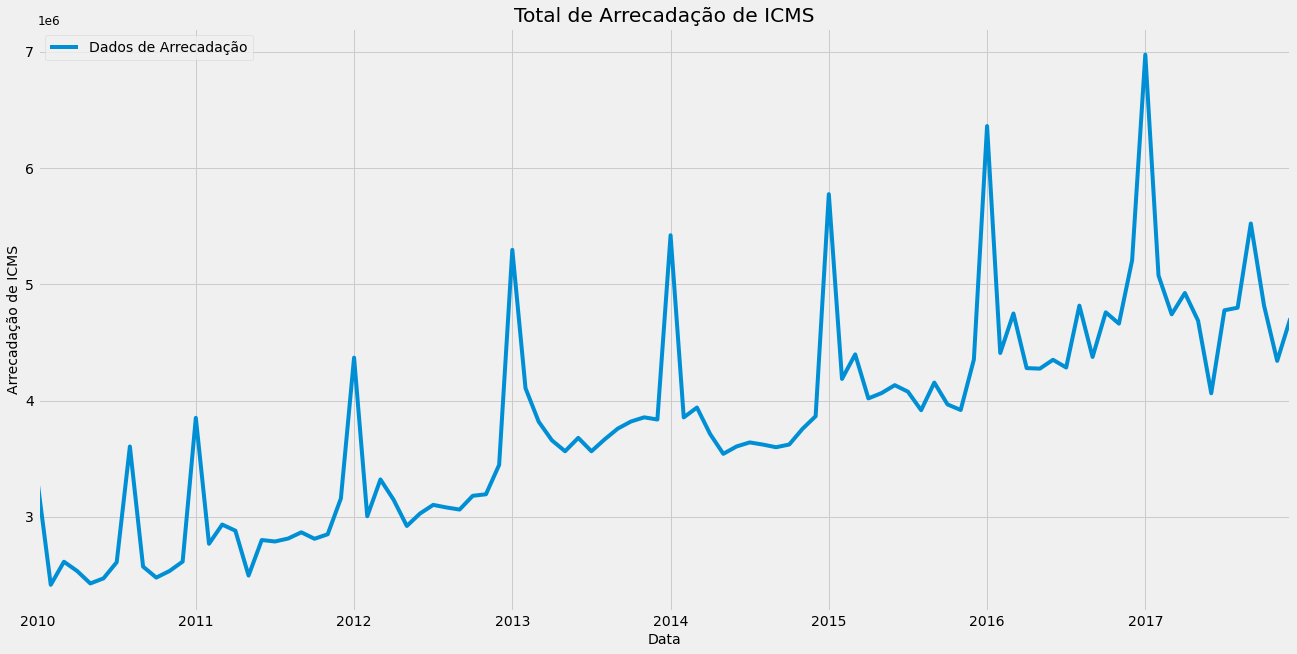

In [9]:
# Plot
target.plot(title = 'Total de Arrecadação de ICMS', fontsize = 14, label = 'Dados de Arrecadação') 
plt.xlabel("Data") 
plt.ylabel("Arrecadação de ICMS") 
plt.legend(loc = 'best') 
plt.show()

In [10]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

72 24


In [11]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

### Função Para o Cálculo da Acurácia

In [12]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo LSTM

A rede Long Short-Term Memory, ou LSTM, é uma rede neural recorrente treinada usando Backpropagation Through Time e supera o problema da dissipação do gradiente (isso é explicado no Deep Learning Book).

Como tal, o modelo pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Em vez de neurônios, as redes LSTM possuem blocos de memória conectados através de camadas.

Um bloco possui componentes que o tornam mais inteligente que um neurônio clássico e uma memória para sequências recentes. Um bloco contém portas que gerenciam o estado e a saída do bloco. Um bloco opera sobre uma sequência de entrada e cada porta dentro de um bloco usa as unidades de ativação sigmóide para controlar se são acionadas ou não, condicionando a mudança de estado e a adição de informações que fluem através do bloco.

Existem três tipos de portas dentro de uma unidade:

- Forget Gate: decide condicionalmente quais informações jogar fora do bloco.
- Input Gate: decide condicionalmente quais valores da entrada atualizar o estado da memória.
- Output Gate: decide condicionalmente o que enviar com base na entrada e na memória do bloco.

Cada unidade é como uma máquina de mini estado onde os portões das unidades têm pesos que são aprendidos durante o procedimento de treinamento.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.

In [13]:
# Cria o scaler para dimensionar nossos dados entre 0 e 1
scaler = MinMaxScaler()

In [14]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)

MinMaxScaler()

In [15]:
# Aplica o mesmo scaler aos dados de treino 
# (Não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelo)
trainset = scaler.transform(trainset)

Aqui definimos os hiperparâmetros.

In [16]:
# Número de repetições
n_rep = 20

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 24 séries para prever as 24 séries seguintes)
n_input = 24

# Comprimento das sequências de saída (em número de timesteps)
n_output = 24
# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [17]:
# Generator
generator = TimeseriesGenerator(trainset, 
                                trainset, 
                                length = n_output,
                                batch_size = size_batch)

Podemos agora criar o modelo.

Para começar a aplicação de Deep Learning ao nosso problema criaremos um modelo básico de LSTM que chamarei de LSTM Padrão.

Aqui está a principal diferença dos modelos de Deep Learning para outros métodos de previsão de séries temporais. Temos que criar o modelo com cada camada da rede neural.

Como trabalharemos com batches de dados da série que serão passados pela rede várias vezes, vamos criar o modelo e gerar os batches de dados a cada passada de um loop. As camadas de rede nada mais são que operações matemáticas.

Nas próximas aulas ensinarei a você como definir os parâmetros da rede (como número de neurônios e dropout). Por agora, leia os comentários em cada linha de código abaixo.

In [18]:
# Criação e treinamento do modelo LSTM Padrão
start = time()

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Podemos adicionar agora a primeira camada da rede, ou camada de entrada.
    # Esta é a camada que recebe os dados.
    modelo_lstm.add(LSTM(50, activation = 'relu', input_shape = (n_input, n_features)))
    
    # A camada de Dropout aplica regularização à rede, removendo alguns neurônios e evitando overfitting
    modelo_lstm.add(Dropout(0.10))
    
    # Adicionamos a primeira camada intermediária ou oculta
    modelo_lstm.add(Dense(100, activation = 'relu'))
    
    # Adicionamos a segunda camada intermediária ou oculta
    modelo_lstm.add(Dense(100, activation = 'relu'))
    
    # Adicionamos a camada de saída e tudo que precisamos é de 1 neurônio pois estamos prevendo apenas 1 valor.
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = target[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/200
5/5 [==============================] - 8s 2s/step - loss: 0.1582
Epoch 2/200
5/5 [==============================] - 0s 78ms/step - loss: 0.0845
Epoch 3/200
5/5 [==============================] - 0s 80ms/step - loss: 0.0343
Epoch 4/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0305
Epoch 5/200
5/5 [==============================] - 0s 78ms/step - loss: 0.0310
Epoch 6/200
5/5 [==============================] - 0s 78ms/step - loss: 0.0241
Epoch 7/200
5/5 [==============================] - 0s 82ms/step - loss: 0.0261
Epoch 8/200
5/5 [==============================] - 0s 78ms/step - loss: 0.0276
Epoch 9/200
5/5 [==============================] - 0s 79ms/step - loss: 0.0254
Epoch 10/200
5/5 [==============================] - 0s 77ms/step - loss: 0.0247
Epoch 11/200
5/5 [==============================] - 0s 77ms/step - loss: 0.0257
Epoch 12/200
5/5 [==============================] - 0s 76ms/step - loss: 0.0241
Epoch 13/200
5/5 [==============================] -

Epoch 4/200
5/5 [==============================] - 0s 78ms/step - loss: 0.0256
Epoch 5/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0331
Epoch 6/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0327
Epoch 7/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0269
Epoch 8/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0271
Epoch 9/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0253
Epoch 10/200
5/5 [==============================] - 0s 83ms/step - loss: 0.0231
Epoch 11/200
5/5 [==============================] - 0s 91ms/step - loss: 0.0249
Epoch 12/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0255
Epoch 13/200
5/5 [==============================] - 0s 83ms/step - loss: 0.0243
Epoch 14/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0252
Epoch 15/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0245
Epoch 16/200
5/5 [============================

5/5 [==============================] - 0s 83ms/step - loss: 0.0194
Epoch 107/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0191
Epoch 108/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0198
Epoch 109/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0174
Epoch 110/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0190
Epoch 111/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0202
Epoch 112/200
5/5 [==============================] - 0s 92ms/step - loss: 0.0224
Epoch 113/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0214
Epoch 114/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0193
Epoch 115/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0193
Epoch 116/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0209
Epoch 117/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0190
Epoch 118/200
5/5 [=======================

5/5 [==============================] - 0s 90ms/step - loss: 0.0180
Epoch 109/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0188
Epoch 110/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0157
Epoch 111/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0134
Epoch 112/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0123
Epoch 113/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0104
Epoch 114/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0132
Epoch 115/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0144
Epoch 116/200
5/5 [==============================] - 0s 83ms/step - loss: 0.0256
Epoch 117/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0276
Epoch 118/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0221
Epoch 119/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0219
Epoch 120/200
5/5 [=======================

5/5 [==============================] - 0s 90ms/step - loss: 0.0213
Epoch 111/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0189
Epoch 112/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0181
Epoch 113/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0189
Epoch 114/200
5/5 [==============================] - 0s 82ms/step - loss: 0.0188
Epoch 115/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0182
Epoch 116/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0178
Epoch 117/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0167
Epoch 118/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0176
Epoch 119/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0173
Epoch 120/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0167
Epoch 121/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0176
Epoch 122/200
5/5 [=======================

5/5 [==============================] - 0s 89ms/step - loss: 0.0245
Epoch 12/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0262
Epoch 13/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0259
Epoch 14/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0242
Epoch 15/200
5/5 [==============================] - 0s 83ms/step - loss: 0.0241
Epoch 16/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0264
Epoch 17/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0270
Epoch 18/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0247
Epoch 19/200
5/5 [==============================] - 1s 116ms/step - loss: 0.0243
Epoch 20/200
5/5 [==============================] - 0s 96ms/step - loss: 0.0245
Epoch 21/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0242
Epoch 22/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0258
Epoch 23/200
5/5 [==============================] - 

5/5 [==============================] - 0s 92ms/step - loss: 0.0249
Epoch 15/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0231
Epoch 16/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0250
Epoch 17/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0252
Epoch 18/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0259
Epoch 19/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0235
Epoch 20/200
5/5 [==============================] - 0s 91ms/step - loss: 0.0232
Epoch 21/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0236
Epoch 22/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0245
Epoch 23/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0237
Epoch 24/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0255
Epoch 25/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0245
Epoch 26/200
5/5 [==============================] - 0

5/5 [==============================] - 0s 87ms/step - loss: 0.0246
Epoch 16/200
5/5 [==============================] - 0s 82ms/step - loss: 0.0249
Epoch 17/200
5/5 [==============================] - 0s 83ms/step - loss: 0.0248
Epoch 18/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0241
Epoch 19/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0249
Epoch 20/200
5/5 [==============================] - 0s 91ms/step - loss: 0.0242
Epoch 21/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0253
Epoch 22/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0246
Epoch 23/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0243
Epoch 24/200
5/5 [==============================] - 0s 83ms/step - loss: 0.0243
Epoch 25/200
5/5 [==============================] - 0s 82ms/step - loss: 0.0229
Epoch 26/200
5/5 [==============================] - 0s 82ms/step - loss: 0.0242
Epoch 27/200
5/5 [==============================] - 0

5/5 [==============================] - 0s 84ms/step - loss: 0.0208
Epoch 118/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0199
Epoch 119/200
5/5 [==============================] - 0s 83ms/step - loss: 0.0182
Epoch 120/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0190
Epoch 121/200
5/5 [==============================] - 0s 81ms/step - loss: 0.0211
Epoch 122/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0187
Epoch 123/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0179
Epoch 124/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0194
Epoch 125/200
5/5 [==============================] - 0s 95ms/step - loss: 0.0181
Epoch 126/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0182
Epoch 127/200
5/5 [==============================] - 0s 82ms/step - loss: 0.0179
Epoch 128/200
5/5 [==============================] - 0s 83ms/step - loss: 0.0177
Epoch 129/200
5/5 [======================

5/5 [==============================] - 0s 89ms/step - loss: 0.0206
Epoch 120/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0179
Epoch 121/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0160
Epoch 122/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0157
Epoch 123/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0175
Epoch 124/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0161
Epoch 125/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0172
Epoch 126/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0178
Epoch 127/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0188
Epoch 128/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0157
Epoch 129/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0157
Epoch 130/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0155
Epoch 131/200
5/5 [=======================

Epoch 20/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0242
Epoch 21/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0252
Epoch 22/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0255
Epoch 23/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0252
Epoch 24/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0250
Epoch 25/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0237
Epoch 26/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0235
Epoch 27/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0242
Epoch 28/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0235
Epoch 29/200
5/5 [==============================] - 0s 91ms/step - loss: 0.0236
Epoch 30/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0236
Epoch 31/200
5/5 [==============================] - 0s 91ms/step - loss: 0.0248
Epoch 32/200
5/5 [======================

5/5 [==============================] - 0s 85ms/step - loss: 0.0238
Epoch 22/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0245
Epoch 23/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0241
Epoch 24/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0235
Epoch 25/200
5/5 [==============================] - 0s 91ms/step - loss: 0.0245
Epoch 26/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0244
Epoch 27/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0242: 0s - loss: 0.023
Epoch 28/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0228
Epoch 29/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0256
Epoch 30/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0243
Epoch 31/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0232
Epoch 32/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0245
Epoch 33/200
5/5 [=================

5/5 [==============================] - 0s 88ms/step - loss: 0.0245
Epoch 24/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0240
Epoch 25/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0251
Epoch 26/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0249
Epoch 27/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0245
Epoch 28/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0244: 0s - loss: 0.0
Epoch 29/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0249
Epoch 30/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0243
Epoch 31/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0241
Epoch 32/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0235
Epoch 33/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0241
Epoch 34/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0247
Epoch 35/200
5/5 [===================

5/5 [==============================] - 0s 88ms/step - loss: 0.0247
Epoch 26/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0248
Epoch 27/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0245
Epoch 28/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0243
Epoch 29/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0261
Epoch 30/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0233
Epoch 31/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0249
Epoch 32/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0245
Epoch 33/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0238
Epoch 34/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0238
Epoch 35/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0249
Epoch 36/200
5/5 [==============================] - 0s 92ms/step - loss: 0.0252
Epoch 37/200
5/5 [==============================] - 0

5/5 [==============================] - 0s 85ms/step - loss: 0.0240
Epoch 28/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0245
Epoch 29/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0242
Epoch 30/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0231
Epoch 31/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0242
Epoch 32/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0247
Epoch 33/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0244
Epoch 34/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0235
Epoch 35/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0243
Epoch 36/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0250
Epoch 37/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0248
Epoch 38/200
5/5 [==============================] - 0s 86ms/step - loss: 0.0237
Epoch 39/200
5/5 [==============================] - 0

5/5 [==============================] - 0s 89ms/step - loss: 0.0241
Epoch 30/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0233
Epoch 31/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0251
Epoch 32/200
5/5 [==============================] - 0s 92ms/step - loss: 0.0234
Epoch 33/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0235
Epoch 34/200
5/5 [==============================] - 0s 90ms/step - loss: 0.0237
Epoch 35/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0236
Epoch 36/200
5/5 [==============================] - 0s 89ms/step - loss: 0.0253
Epoch 37/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0246
Epoch 38/200
5/5 [==============================] - 0s 87ms/step - loss: 0.0254
Epoch 39/200
5/5 [==============================] - 0s 88ms/step - loss: 0.0251
Epoch 40/200
5/5 [==============================] - 0s 85ms/step - loss: 0.0246
Epoch 41/200
5/5 [==============================] - 0

5/5 [==============================] - 1s 100ms/step - loss: 0.0239
Epoch 32/200
5/5 [==============================] - 0s 100ms/step - loss: 0.0233
Epoch 33/200
5/5 [==============================] - 0s 99ms/step - loss: 0.0248
Epoch 34/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0240
Epoch 35/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0256
Epoch 36/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0243
Epoch 37/200
5/5 [==============================] - 0s 100ms/step - loss: 0.0241
Epoch 38/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0256
Epoch 39/200
5/5 [==============================] - 0s 99ms/step - loss: 0.0235
Epoch 40/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0236
Epoch 41/200
5/5 [==============================] - 1s 100ms/step - loss: 0.0242
Epoch 42/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0237
Epoch 43/200
5/5 [=========================

Epoch 132/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0197
Epoch 133/200
5/5 [==============================] - 0s 99ms/step - loss: 0.0198
Epoch 134/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0191
Epoch 135/200
5/5 [==============================] - 1s 100ms/step - loss: 0.0197
Epoch 136/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0197
Epoch 137/200
5/5 [==============================] - 0s 100ms/step - loss: 0.0200
Epoch 138/200
5/5 [==============================] - 0s 99ms/step - loss: 0.0199
Epoch 139/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0214
Epoch 140/200
5/5 [==============================] - 0s 99ms/step - loss: 0.0198
Epoch 141/200
5/5 [==============================] - 0s 99ms/step - loss: 0.0191
Epoch 142/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0192
Epoch 143/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0185
Epoch 144/200
5/5 [=

5/5 [==============================] - 0s 100ms/step - loss: 0.0176
Epoch 134/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0187
Epoch 135/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0173
Epoch 136/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0149
Epoch 137/200
5/5 [==============================] - 0s 98ms/step - loss: 0.0192
Epoch 138/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0152
Epoch 139/200
5/5 [==============================] - 0s 97ms/step - loss: 0.0153
Epoch 140/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0161
Epoch 141/200
5/5 [==============================] - 0s 100ms/step - loss: 0.0125
Epoch 142/200
5/5 [==============================] - 0s 100ms/step - loss: 0.0165
Epoch 143/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0138
Epoch 144/200
5/5 [==============================] - 0s 100ms/step - loss: 0.0136
Epoch 145/200
5/5 [=============

Epoch 134/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0142
Epoch 135/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0143
Epoch 136/200
5/5 [==============================] - 0s 100ms/step - loss: 0.0140
Epoch 137/200
5/5 [==============================] - 0s 100ms/step - loss: 0.0151
Epoch 138/200
5/5 [==============================] - 1s 100ms/step - loss: 0.0142
Epoch 139/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0135
Epoch 140/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0111
Epoch 141/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0123
Epoch 142/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0097
Epoch 143/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0128
Epoch 144/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0145
Epoch 145/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0111
Epoch 146/200
5/

5/5 [==============================] - 1s 101ms/step - loss: 0.0200
Epoch 135/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0196
Epoch 136/200
5/5 [==============================] - 1s 100ms/step - loss: 0.0204
Epoch 137/200
5/5 [==============================] - 1s 100ms/step - loss: 0.0208
Epoch 138/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0174
Epoch 139/200
5/5 [==============================] - 0s 98ms/step - loss: 0.0193
Epoch 140/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0193
Epoch 141/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0195
Epoch 142/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0216
Epoch 143/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0181
Epoch 144/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0183
Epoch 145/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0195
Epoch 146/200
5/5 [============

Epoch 135/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0218
Epoch 136/200
5/5 [==============================] - 1s 106ms/step - loss: 0.0090
Epoch 137/200
5/5 [==============================] - 1s 113ms/step - loss: 0.0103
Epoch 138/200
5/5 [==============================] - 1s 113ms/step - loss: 0.0082
Epoch 139/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0065
Epoch 140/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0050
Epoch 141/200
5/5 [==============================] - 1s 112ms/step - loss: 0.0065
Epoch 142/200
5/5 [==============================] - 1s 123ms/step - loss: 0.0028
Epoch 143/200
5/5 [==============================] - 1s 112ms/step - loss: 0.0048
Epoch 144/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0033
Epoch 145/200
5/5 [==============================] - 1s 106ms/step - loss: 0.0038
Epoch 146/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0034
Epoch 147/200
5/

5/5 [==============================] - 1s 103ms/step - loss: 0.0233
Epoch 136/200
5/5 [==============================] - 1s 100ms/step - loss: 0.0248
Epoch 137/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0219
Epoch 138/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0250
Epoch 139/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0218
Epoch 140/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0230
Epoch 141/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0211
Epoch 142/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0214
Epoch 143/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0215
Epoch 144/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0215
Epoch 145/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0211
Epoch 146/200
5/5 [==============================] - 1s 101ms/step - loss: 0.0206
Epoch 147/200
5/5 [===========

O mais delicado na criação do modelo é definir o input_shape da primeira camada. É isso que o modelo espera como entrada para cada amostra em termos do número de etapas de tempo e do número de recursos.

Estamos trabalhando com uma série univariada, portanto, o número de recursos é um, para uma variável.

O número de etapas de tempo como entrada é o número que escolhemos para prever as sequências de saída. Em nosso exemplo, estamos usando 24 sequências para prever 24 sequências.

Quase sempre temos várias amostras; portanto, o modelo espera que o componente de entrada dos dados de treinamento tenha as dimensões ou a forma:

[samples, timesteps, features]

Em nosso exemplo, nós temos:

- samples = n_rep (20)
- timesteps = n_input (24)
- features = n_features (1)

Agora calculamos o erro modelo.

In [19]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [20]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [21]:
# Previsões finais
resultado_final

array([[5037635.7933364 ],
       [4257326.39097597],
       [4230768.07371349],
       [4168910.14566556],
       [4118398.2858053 ],
       [4107666.15584309],
       [4103305.55850176],
       [4100184.67164837],
       [4104614.51612749],
       [4121163.74106197],
       [4161095.78162397],
       [4307283.61795605],
       [5297196.41728911],
       [4405028.59858606],
       [4405874.92245677],
       [4294619.06083704],
       [4277337.95277624],
       [4288494.57625326],
       [4282518.44764255],
       [4223713.61103218],
       [4253782.56244849],
       [4202733.62553197],
       [4183702.74196741],
       [4434602.38265749]])

In [22]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((24,))

In [23]:
# Previsões finais
resultado_final

array([5037635.7933364 , 4257326.39097597, 4230768.07371349,
       4168910.14566556, 4118398.2858053 , 4107666.15584309,
       4103305.55850176, 4100184.67164837, 4104614.51612749,
       4121163.74106197, 4161095.78162397, 4307283.61795605,
       5297196.41728911, 4405028.59858606, 4405874.92245677,
       4294619.06083704, 4277337.95277624, 4288494.57625326,
       4282518.44764255, 4223713.61103218, 4253782.56244849,
       4202733.62553197, 4183702.74196741, 4434602.38265749])

In [24]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)
modelo_lstm_performance

MSE das previsões é 772409698156.345
RMSE das previsões é 878868.4191
MAPE das previsões é 11.7861


Nossa rede não apresentou um resultado magnífico, mas não foi ruim. Está no mesmo nível de um modelo SARIMAX 
A diferença é que ainda temos muitas opções de otimização do Modelo LSTM.
Abaixo o plot das previsões.

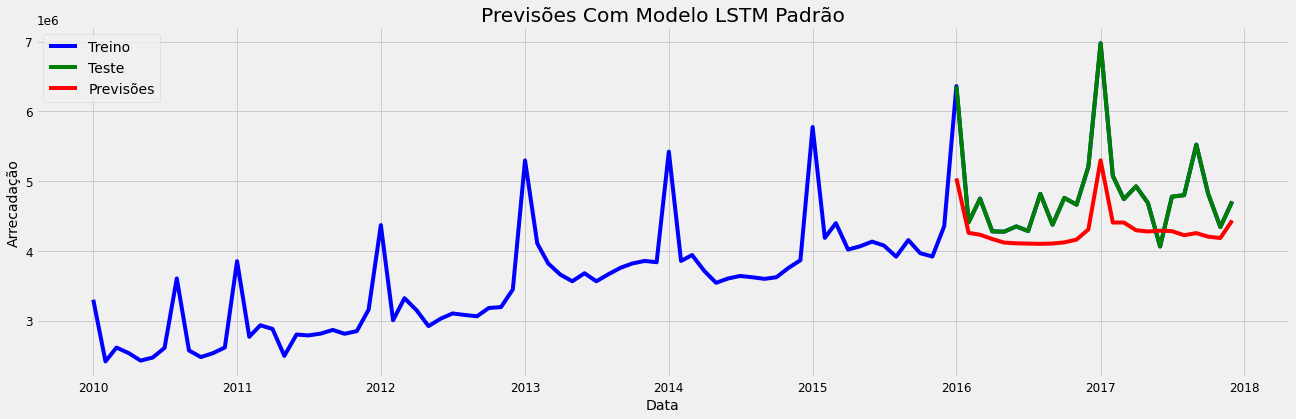

In [25]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Treino', color = 'Blue')
plt.plot(teste, label = 'Teste', color = 'green')

# Previsões
plt.plot(target[72:].index, resultado_final, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('Arrecadação')
plt.legend(loc = 'upper left')
plt.show()

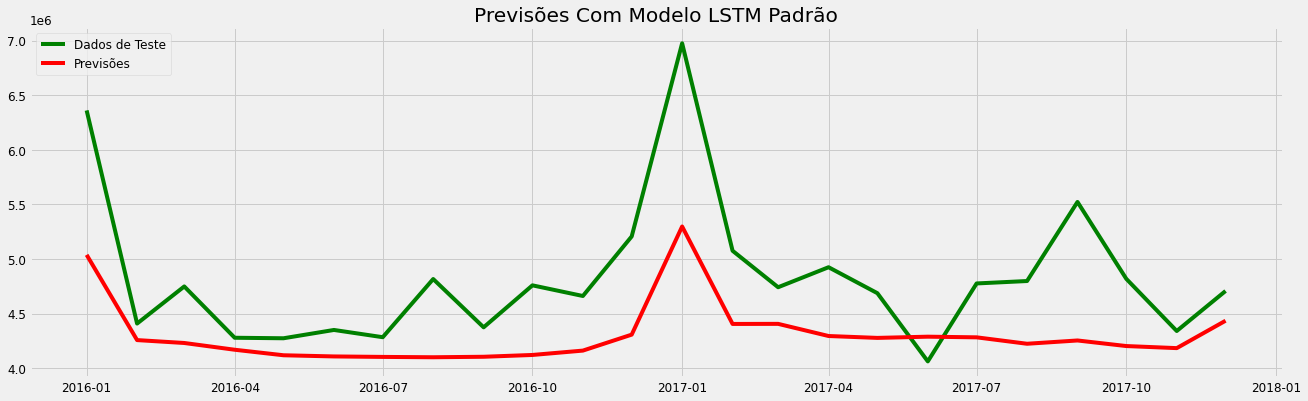

In [26]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[72:].index, resultado_final, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Padrão')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Vamos fazer o Forecasting para 24 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [27]:
# Última data da série
target.index[-1]

Timestamp('2017-12-01 00:00:00')

In [28]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(months = x) for x in range(0, 25)]

In [29]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [30]:
# Nossa série original é um objeto do tipo pd.Series
#type(target)

In [31]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [32]:
# Visualiza os dados
#df_original.head()

In [33]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [34]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [35]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [36]:
# Visualiza o dataframe
df_forecasting

,Arrecadacao,Prediction
2010-01-01,3299311.0,NaN
2010-02-01,2415158.0,NaN
2010-03-01,2613292.0,NaN
2010-04-01,2533679.0,NaN
2010-05-01,2426702.0,NaN
...,...,...
2019-08-01,NaN,3.800822e+06
2019-09-01,NaN,3.759981e+06
2019-10-01,NaN,3.719272e+06
2019-11-01,NaN,3.693542e+06


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de validação, 24 meses que correspondem aos 24 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 24 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

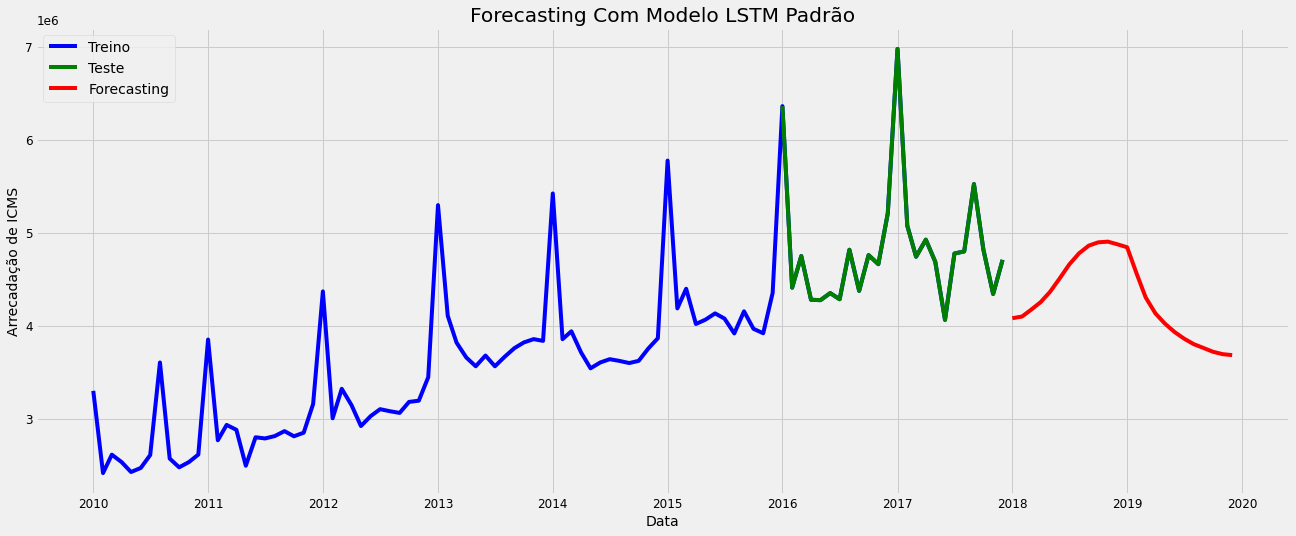

In [37]:
# Plot
plt.figure(figsize = (20, 8))

# Série original
plt.plot(target.index, target.values, label = 'Treino', color = 'Blue')
plt.plot(teste, label = 'Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'],
         label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('Arrecadação de ICMS')
plt.legend(loc = 'upper left')
plt.show()

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (12,9) - AIC = 2044.48 e RMSE = 706415.3914
- Modelo 16 --> Modelo ARIMA (2,1,1) - AIC = 2106,43 e RMSE = 1099391.3958
- Modelo 17 --> Modelo SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC = 1251.06 e RMSE = 332666.2626
- Modelo 18 --> Modelo SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC = 1233.47 e RMSE = 336782.4202
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 15.8048 e RMSE = 1037107.0089   -   (5 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 11.7861 e RMSE = 878868.4191   -   (20 repetições)

Nosso modelo de Deep Learning veio para a briga como um candidato de peso. Nas próximas aulas vamos otimizar o modelo e trabalhar com diferentes arquiteturas LSTM.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim